In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
#Python SQL toolkit and ORM
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
#Database Reflection
Base = automap_base()
#Table Reflection
Base.prepare(engine, reflect=True)

In [7]:
#Viewing the classes.
Base.classes.keys()

['measurement', 'station']

In [8]:
#Saving references to each table.
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
#Creating a link from Python to the database.
session = Session(engine)

# Exploratory Climate Analysis

In [30]:
inspector = inspect(engine)
inspector.get_table_names()

columns = inspector.get_columns('station')
columns

[{'autoincrement': 'auto',
  'default': None,
  'name': 'id',
  'nullable': False,
  'primary_key': 1,
  'type': INTEGER()},
 {'autoincrement': 'auto',
  'default': None,
  'name': 'station',
  'nullable': True,
  'primary_key': 0,
  'type': TEXT()},
 {'autoincrement': 'auto',
  'default': None,
  'name': 'name',
  'nullable': True,
  'primary_key': 0,
  'type': TEXT()},
 {'autoincrement': 'auto',
  'default': None,
  'name': 'latitude',
  'nullable': True,
  'primary_key': 0,
  'type': FLOAT()},
 {'autoincrement': 'auto',
  'default': None,
  'name': 'longitude',
  'nullable': True,
  'primary_key': 0,
  'type': FLOAT()},
 {'autoincrement': 'auto',
  'default': None,
  'name': 'elevation',
  'nullable': True,
  'primary_key': 0,
  'type': FLOAT()}]

In [10]:
inspector = inspect(engine)
inspector.get_table_names()

columns = inspector.get_columns('measurement')
columns

[{'autoincrement': 'auto',
  'default': None,
  'name': 'id',
  'nullable': False,
  'primary_key': 1,
  'type': INTEGER()},
 {'autoincrement': 'auto',
  'default': None,
  'name': 'station',
  'nullable': True,
  'primary_key': 0,
  'type': TEXT()},
 {'autoincrement': 'auto',
  'default': None,
  'name': 'date',
  'nullable': True,
  'primary_key': 0,
  'type': TEXT()},
 {'autoincrement': 'auto',
  'default': None,
  'name': 'prcp',
  'nullable': True,
  'primary_key': 0,
  'type': FLOAT()},
 {'autoincrement': 'auto',
  'default': None,
  'name': 'tobs',
  'nullable': True,
  'primary_key': 0,
  'type': FLOAT()}]

In [11]:
#Last date in database.
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
#print(last_date)
#=('2017-08-23',)

#One year before the last date.
previous_year = dt.date(2017,8,23) - dt.timedelta(days=365)
previous_year

datetime.date(2016, 8, 23)

In [12]:
#Query to retrieve the data.
precipitation = session.query(Measurement.date,Measurement.prcp).filter(Measurement.date > previous_year).order_by(Measurement.date).all()
#precipitation

#Switching to a Pandas DataFrame.
precipitation_df = pd.DataFrame(precipitation, columns=['Date','Precipitation'])

#Setting the index.
precipitation_df.set_index('Date').head(25)

,Precipitation
Date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,NaN
2016-08-24,1.22
2016-08-24,2.15
2016-08-24,1.45
2016-08-25,0.08
2016-08-25,0.08


![precipitation](Images/precipitation.png)

<Figure size 450x360 with 0 Axes>

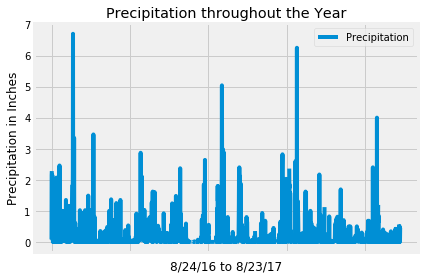

In [13]:
figure_1 = plt.figure(figsize=(6.25,5))
precipitation_df.plot('Date', 'Precipitation')
plt.xlabel("8/24/16 to 8/23/17")
plt.ylabel("Precipitation in Inches")
plt.title("Precipitation throughout the Year")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("Figures/Figure_1.png")
plt.show()

In [14]:
precipitation_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [15]:
#Saving the summary statistics for later.
precipitation_df.describe().to_csv("Figures/Summary_Statistics.csv")

![describe](Images/describe.png)

In [16]:
#Number of stations in dataset.
location_station = session.query(Measurement).group_by(Measurement.station).count()
print("There are {} stations.".format(location_station))

There are 9 stations.


In [17]:
#List of stations by total activity (measured by total recorded observations).
weather_records = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()

for station, count in weather_records:
    print("Station",station,"has",count, "weather records.")

Station USC00519281 has 2772 weather records.
Station USC00519397 has 2724 weather records.
Station USC00513117 has 2709 weather records.
Station USC00519523 has 2669 weather records.
Station USC00516128 has 2612 weather records.
Station USC00514830 has 2202 weather records.
Station USC00511918 has 1979 weather records.
Station USC00517948 has 1372 weather records.
Station USC00518838 has 511 weather records.


In [18]:
#The lowest weather temperature at the most popular weather station.
active_station_data_inf = session.query(Measurement.station, Measurement.date, Measurement.tobs).filter(Measurement.station == weather_records[0][0]).filter(Measurement.date > previous_year).order_by(Measurement.date).all()

active_data_df_inf = pd.DataFrame(active_station_data_inf, columns=["Station","Date","Temperature"])

sorted_df_inf = active_data_df_inf.sort_values("Temperature")

sorted_df_inf.iloc[0:5]

,Station,Date,Temperature
162,USC00519281,2017-02-02,59.0
169,USC00519281,2017-02-09,59.0
168,USC00519281,2017-02-08,59.0
249,USC00519281,2017-04-30,60.0
163,USC00519281,2017-02-03,60.0


In [19]:
#The mean weather temperature at the most popular weather station.
active_station_data_mu = session.query(Measurement.station, Measurement.date, Measurement.tobs).filter(Measurement.station == weather_records[0][0]).filter(Measurement.date > previous_year).order_by(Measurement.date).all()

active_data_df_mu = pd.DataFrame(active_station_data_mu, columns=["Station","Date","Temperature"])


round(active_data_df_mu.drop(["Station", "Date"], axis=1).mean(), 2)


Temperature    73.1
dtype: float64

In [20]:
#The highest weather temperature at the most popular weather station.
active_station_data_sup = session.query(Measurement.station, Measurement.date, Measurement.tobs).filter(Measurement.station == weather_records[0][0]).filter(Measurement.date > previous_year).order_by(Measurement.date).all()


active_data_df_sup = pd.DataFrame(active_station_data_sup, columns=["Station","Date","Temperature"])


sorted_df_sup = active_data_df_sup.sort_values('Temperature', ascending = False)


sorted_df_sup.iloc[0:5]

,Station,Date,Temperature
344,USC00519281,2017-08-06,83.0
333,USC00519281,2017-07-23,82.0
339,USC00519281,2017-07-29,82.0
343,USC00519281,2017-08-05,82.0
338,USC00519281,2017-07-28,81.0


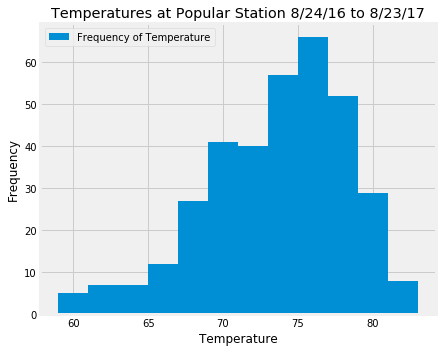

In [21]:
#12 month data on the most popular weather station.
twelve_data = session.query(Measurement.tobs).filter(Measurement.station == "USC00519281", Measurement.station == Station.station, Measurement.date > previous_year).all()
twelve_data

temps = [temp[0] for temp in twelve_data]

figure_2 = plt.figure(figsize=(6.25,5))
plt.hist(temps, bins=12)
plt.title("Temperatures at Popular Station 8/24/16 to 8/23/17")
plt.ylabel('Frequency')
plt.xlabel('Temperature')
labels = ['Frequency of Temperature']
plt.legend(labels)
plt.grid(True)
plt.tight_layout()
plt.savefig("Figures/Figure_2.png")
plt.show()

![precipitation](Images/station-histogram.png)

In [22]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [23]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
calc_temps('2017-06-06', '2017-06-13')

[(72.0, 77.1923076923077, 83.0)]

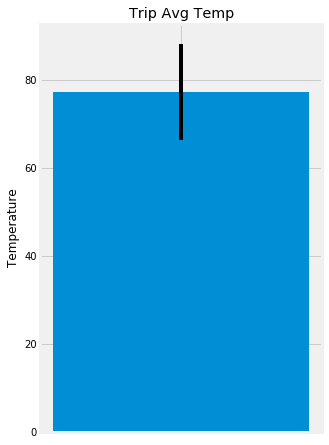

In [24]:
#A bar chart representing the previous cell.
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

calc_temps('2017-06-06', '2017-06-13')    
    
plt.figure(figsize=(4.5,7.5))
plt.bar(1, 77.19, yerr=(83.0 - 72.0), tick_label='')
plt.ylabel("Temperature")
plt.title("Trip Avg Temp")
plt.savefig("Figures/Figure_3.png")
plt.show()

In [25]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [26]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [27]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [28]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [29]:
# Plot the daily normals as an area plot with `stacked=False`
